# COVID-19 Tracker
Using data on COVID-19 from the European Centre for Disease Control (via the website ourworldindata.org), and world population data from the World Bank, and the Python programming language and Jupyter (IPython) Notebook, I generated some charts to help visualize the data. You can skim the code below, and jumpt to the bottom to see the summary charts.

I have made this source code available as open source on the code sharing service GitHub (see https://github.com/bakirl/covid19-tracker) . You can also launch a Jupyter notebook live in your browser using the service called binder (see https://mybinder.org/v2/gh/bakirl/covid19-tracker/master) - this will take a few minutes to launch, after which you can click on the file (covid19.ipynb). Using this code, you can change things such as the countries and range of dates, etc.

## The Code

In [1]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [2]:
# filter warnings, for now!
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Download latest Covid 19 data
df = pd.read_csv("https://covid.ourworldindata.org/data/ecdc/full_data.csv")

# Downloaded population from World Bank
# http://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=csv
pop = pd.read_csv("population.csv", skiprows=4)
pop = pop.set_index('Country Name')
pop = pop['2018'].dropna()

In [4]:
# Default values
values_def = 'new_cases'
start_def = '2020-03-01'
countries_def=['Italy','Spain','United Kingdom','Ireland','China','United States','Iran']

# Set the default size for the figures
plt.rcParams["figure.figsize"] = (14, 10)

In [5]:
# generate a pivot of values for a specified list of countries for a specified range of dates
# @global df - data frame containing Covid 19 data by date and by country
# @global pop - data frome containing population data from 2018
# @param values - one of 'new cases', 'total cases', 'new deaths', total deaths'
# @param start - show data only for dates since this date; format 'yyyy-mm-dd'
# @param countries - show data only for the specified countries
# @param by_pop - set to True to divide numbers by population per country, in millions
def covid(values=values_def, start=start_def, countries=countries_def, by_pop=False, sort=True):
    # filter by date
    df2 = df[df.date >= start]
    # generate a pivot chart
    piv = df2.pivot(index='date', columns='location', values=values)
    # filter by country
    if (countries == []):
        sub = piv.drop(columns='World')
    else:
        sub = piv[countries]
    # setup title of plot
    title=values + " from " + start
    if (by_pop):
        # divide each number by the population, in millions
        pop2 = pop[countries]
        pop2 = pop2/1e6
        pop2 = pop2.transpose()
        sub = sub/pop2.values
        title = title + " per million of population"
    if (sort):
        # sort based on highest value on the most recent date (last row)
        lastrow = sub.shape[0]-1
        lastrow_name = sub.index[lastrow]
        sub.sort_values(by=lastrow_name, axis=1, ascending=False, inplace=True)
    return sub, title

In [6]:
# generate the sub-pivot for all countries in the covid dataframe
sub, title = covid(countries=[])

# not all countries in the covid dataframe are also in the population dataframe
# find the intersection of these two sets
countries_inter_index = pop.index.intersection(sub.columns)
countries_inter = countries_inter_index.values

In [7]:
# Countries with smaller populations are showing up - let's look at 40 countries with the smallest population
pop2=pop[countries_inter].sort_values(ascending=False)
entries=pop2.shape[0]

In [8]:
# Let's only consider countries with population greater than 1m
countries_small = pop2[pop2.values <= 1e6]
countries_large_index = countries_inter_index.difference(countries_small.index)
countries_large = countries_large_index.values

In [38]:
values_range = ['new_cases', 'total_cases', 'new_deaths', 'total_deaths']
# plot the data from the pivot
def covid_plot(n=10, countries=countries_inter, by_pop=False, sort=True, suptitle='', 
               start=start_def, colors=[], normalized=False, rolling_window=7):
    plt.rcParams["figure.figsize"] = (14, 10)
    fig, ax = plt.subplots(2, 2, linewidth=5, edgecolor='black')
    fig.tight_layout(pad=8)
    
    # setup figure title
    if (suptitle==''):
        suptitle = 'Top ' + str(n) + ' Countries'
    if (by_pop):
        suptitle += ', by Population'
    div = "\n"
    if (rolling_window != 1):
        suptitle += div + 'Moving Average over ' + str(rolling_window) + ' days'
        div = ', '
    if (normalized):
        suptitle += div + 'Normalized'
        div = ', '
    fig.suptitle(suptitle, size=18, weight='bold')
    
    for values, axis in zip(values_range, [ax[0][0], ax[0][1], ax[1][0], ax[1][1]]):
        sub, title = covid(countries=countries, by_pop=by_pop, values=values, sort=sort, start=start)
        # set rolling window
        sub = sub.iloc[:, :n].rolling(window=rolling_window).mean()
        if (normalized):
            sub = sub/sub.max(axis=0)
        if (colors == []):
            ax1 = sub.iloc[:,:n].plot(title=title, logy=False, ax=axis, rot=20)
        else:
            ax1 = sub.iloc[:,:n].plot(title=title, logy=False, ax=axis, rot=20, colors=colors)
        ax1.grid(color='grey', linestyle='-', linewidth=0.5, alpha=0.5, axis='both')

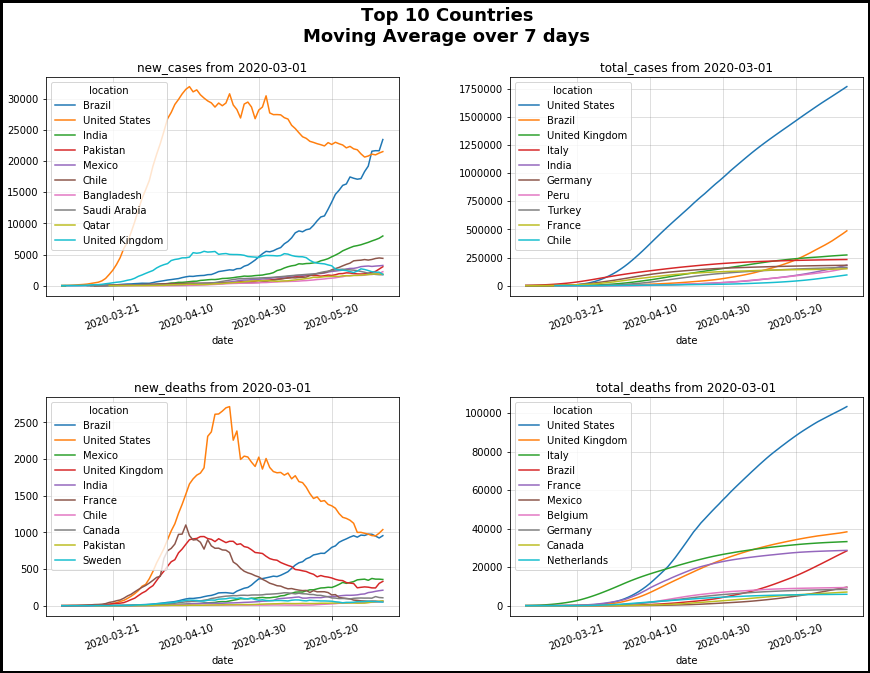

In [39]:
covid_plot()

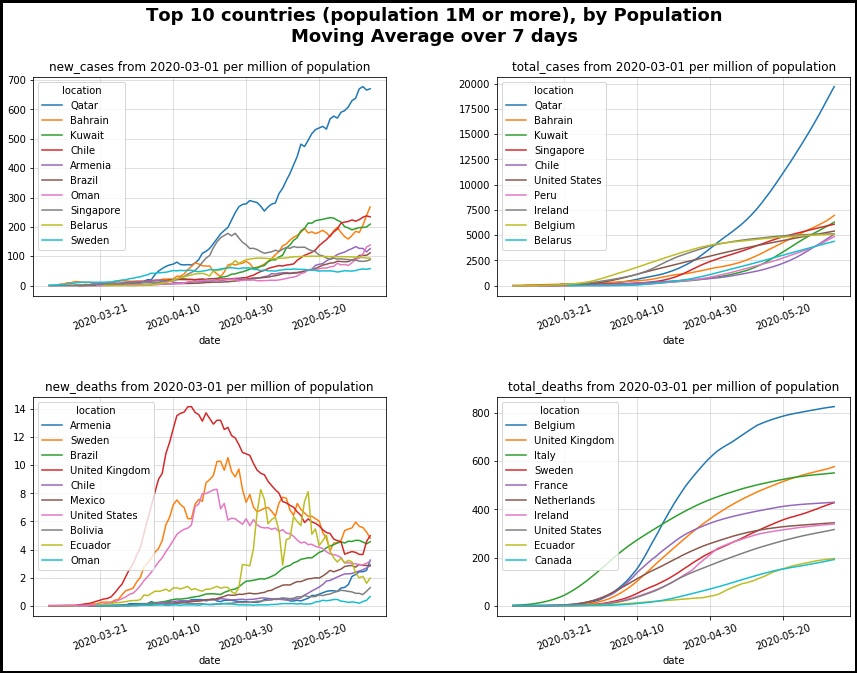

In [40]:
# when sorting by population, exclude smaller countries
covid_plot(by_pop=True, countries=countries_large, suptitle="Top 10 countries (population 1M or more)")

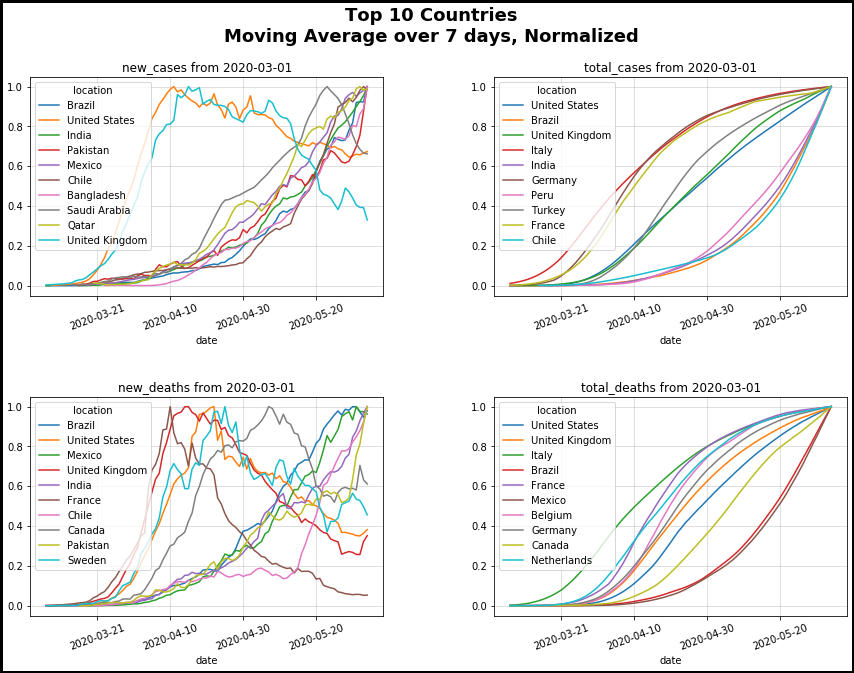

In [41]:
covid_plot(normalized=True)

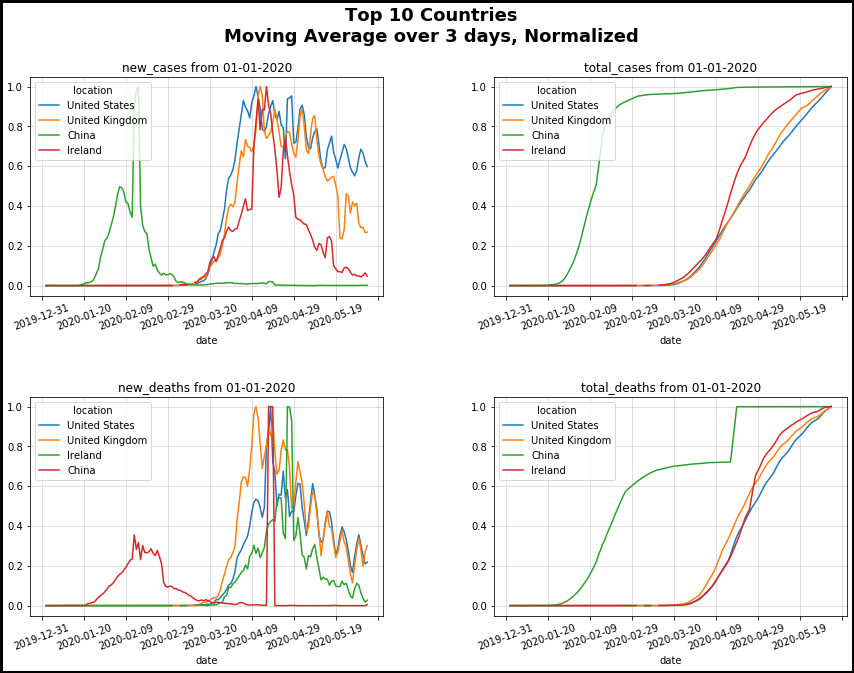

In [42]:
covid_plot(countries=['Ireland', 'United Kingdom', 'United States', 'China'],
          normalized=True, start='01-01-2020', rolling_window=3)